In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Cache coeffs @ self.points
class CubicBezier:
    def __init__(self, p0, p1, p2, p3):
        self.points = [p0, p1, p2, p3]
    
    def calc(self, t):
        T = [
            t * t * t,
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 3, 0, 0],
            [1, 0, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d(self, t):
        T = [
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-3, 9, -9, 3],
            [6, -12, 6, 0],
            [-3, 3, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d2(self, t):
        T = [
            t,
            1
        ]
        coeffs = np.array([
            [-6, 18, -18, 6],
            [6, -12, 6, 0]
        ])
        return T @ coeffs @ self.points
    
    def curvature(self, t, d=None, d2=None):
        if d is None:
            d = self.d(t)
        if d2 is None:
            d2 = self.d2(t)
        return (d[0] * d2[1] - d[1] * d2[0]) / (math.hypot(*d) ** 3)

In [3]:
class BezierSpline:
    def __init__(self, segments):
        self.segments = segments
        for f in dir(CubicBezier):
            if f.startswith('__'):
                continue
            def _apply_to_segment(self, t, *args, func_name=f):
                num = math.ceil(t) - 1
                if num < 0:
                    num = 0
                frac = t - num
                segment = self.segments[num]
                func = getattr(segment, func_name)
                return func(frac, *args)
            setattr(type(self), f, _apply_to_segment)
    
    def max_t(self):
        return len(self.segments)

In [4]:
class CubicHermite:
    def __init__(self, p0, v0, p1, v1):
        self.points = [p0, v0, p1, v1]
    
    def calc(self, t):
        T = [
            t * t * t,
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [2, 1, -2, 1],
            [-3, -2, 3, -1],
            [0, 1, 0, 0],
            [1, 0, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d(self, t):
        T = [
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [6, 3, -6, 3],
            [6, -4, 6, -2],
            [0, 1, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d2(self, t):
        T = [
            t,
            1
        ]
        coeffs = np.array([
            [12, 6, -12, 6],
            [6, -4, 6, -2]
        ])
        return T @ coeffs @ self.points
    
    def curvature(self, t, d=None, d2=None):
        if d is None:
            d = self.d(t)
        if d2 is None:
            d2 = self.d2(t)
        return (d[0] * d2[1] - d[1] * d2[0]) / (math.hypot(*d) ** 3)

In [5]:
class QuinticHermite:
    def __init__(self, p0, v0, a0, p1, v1, a1):
        self.points = [p0, v0, a0, p1, v1, a1]
        self.calc_cache = np.array([
            [-6, -3, -0.5, 6, -3, 0.5],
            [15, 8, 1.5, -15, 7, -1],
            [-10, -6, -1.5, 10, -4, 0.5],
            [0, 0, 0.5, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0]
        ]) @ self.points
        
    def calc(self, t):
        T = [
            t * t * t * t * t,
            t * t * t * t,
            t * t *  t,
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-6, -3, -0.5, 6, -3, 0.5],
            [15, 8, 1.5, -15, 7, -1],
            [-10, -6, -1.5, 10, -4, 0.5],
            [0, 0, 0.5, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [1, 0, 0, 0, 0, 0]
        ])
#         return T @ coeffs @ self.points
        return T @ self.calc_cache
    
    def d(self, t):
        T = [
            t * t * t * t,
            t * t * t,
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-30, -15, -2.5, 30, -15, 2.5],
            [60, 32, 6, -60, 28, -4],
            [-30, -18, -4.5, 30, -12, 1.5],
            [0, 0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d2(self, t):
        T = [
            t * t * t,
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-120, -60, -10, 120, -60, 10],
            [180, 96, 18, -180, 84, -12],
            [-60, -36, -9, 60, -24, 3],
            [0, 0, 1, 0, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def curvature(self, t, d=None, d2=None):
        if d is None:
            d = self.d(t)
        if d2 is None:
            d2 = self.d2(t)
        return (d[0] * d2[1] - d[1] * d2[0]) / (math.hypot(*d) ** 3)

In [6]:
class Constraints:
    def __init__(self, vel, acc, dec, track_width, friction_coeff):
        self.max_vel = vel
        self.max_acc = acc
        self.max_dec = dec
        self.track_width = track_width
        self.friction_coeff = friction_coeff
    
    def max_speed(self, curvature):
        max_turn_speed = 2 * self.max_vel / (2 + abs(curvature) * self.track_width)
        # Scuffed floating point check (reminder for C++ port)
        if curvature == 0:
            return max_turn_speed
        max_slip_speed = math.sqrt(self.friction_coeff / abs(curvature) * 9.81 * 39.3701)
        return min(max_turn_speed, max_slip_speed)

In [7]:
# Iterative generation and replanning
# Average change in heading instead of v * curvature
# Splines and start/end velocities
# Slip constraint conversion factor
# Notion
# Separate out motion profile from trajectory generation
# Start at small displacement or velocity
# Sync MotionProfile and Trajectory
# Are excpetions for alpha even correct? Or need to check constraints after both passes? Add exceptions for backward pass as well?

class MotionProfile:
    def __init__(self, path, constraints, step):
        self.path = path
        self.constraints = constraints
        self.step = step
        
    
    def generate(self, start_v, end_v, start_w, end_w):
        vs = []
        ws = []
        
        t = 0
        d = self.path.d(t)
        theta = math.atan2(d[1], d[0])
        v = start_v
        prev_w = start_w
        
        while t < 1:
            t += self.step / math.hypot(*d)
            d = self.path.d(t)
            next_theta = math.atan2(d[1], d[0])
            w = (next_theta - theta) * (v / self.step)
            theta = next_theta
            # Appending to the previous one, t is incremented only for 
            vs.append(v)
            ws.append(w)

            curvature = w / v
            a = (w - prev_w) * (v / self.step)
            prev_w = w
            max_acc = self.constraints.max_acc - abs(a * self.constraints.track_width / 2)
            v = min(constraints.max_speed(curvature), math.sqrt(v**2 + 2 * max_acc * self.step))
            
        t = 1
        d = self.path.d(t)
        v = end_v
        prev_w = end_w
        
        vs.append(0)
        ws.append(0)
        i = len(vs) - 1
        while t > 0:
            t -= self.step / math.hypot(*d)
            d = self.path.d(t)
            next_theta = math.atan2(d[1], d[0])
            w = -(next_theta - theta) * (v / self.step)
            theta = next_theta
            if abs(v) < abs(vs[i]):
                vs[i] = v
            if abs(w) < abs(ws[i]):
                ws[i] = w
            i -= 1
            
            curvature = w / v
            a = (w - prev_w) * (v / self.step)
            prev_w = w
            max_acc = self.constraints.max_acc - abs(a * self.constraints.track_width / 2)
            v = min(constraints.max_speed(curvature), math.sqrt(v**2 + 2 * max_acc * self.step))
        
        self.vs = vs
        self.ws = ws
    
#     def gen(self, start_v, end_v, start_w, end_w):
#         vs = []
#         ws = []
#         curvatures = []

#         v = start_v
#         prev_w = start_w
#         vs.append(v)
#         ws.append(prev_w)
#         d = self.path.d(0)
#         i = 0
        
#         theta = math.atan2(d[1], d[0])
        
#         t = 0
#         while t < 1:
#             # technically wrong
#             t += self.step / math.hypot(*d)
#             d = self.path.d(t)
#             d2 = self.path.d2(t)
            
#             next_theta = math.atan2(d[1], d[0])
#             w = (next_theta - theta) * (v / self.step)
#             theta = next_theta
            
#             # can make t none (differs from Trajectory)
#             curvature = self.path.curvature(t, d, d2)
#             curvatures.append(curvature)
            
#             w = v * curvature
#             a = (w - prev_w) * (v / self.step)
#             prev_w = w
            
#             max_acc = self.constraints.max_acc - abs(a * self.constraints.track_width / 2)
# #             print(v, w, a)
#             if max_acc < 0:
#                 raise ValueError('Cannot solve (try reducing curvature or step size)')
#             v = min(constraints.max_speed(curvature), math.sqrt(v**2 + 2 * max_acc * self.step))
            
#             vs.append(v)
#             ws.append(w)

#         v = end_v
#         prev_w = end_w
#         vs.append(v)
#         ws.append(prev_w)
#         d = self.path.d(1)
        
#         i = len(vs) - 2
#         while i > 0:
#             curvature = curvatures.pop(-1)
#             w = v * curvature
#             a = (w - prev_w) * (v / self.step)
#             prev_w = w
            
#             max_acc = self.constraints.max_dec - abs(a * self.constraints.track_width / 2)
#             v = min(constraints.max_speed(curvature), math.sqrt(v**2 + 2 * max_acc * self.step))
            
#             if abs(v) < abs(vs[i]):
#                 vs[i] = v
#             # Decide w by itself? (comment out)
#             if abs(w) < abs(ws[i]):
#                 ws[i] = w
#             i -= 1
        
#         self.vs = vs
#         self.ws = ws
    
    def get_wheel_speeds(self, dist, i=None):
        if i is None:
            i = math.ceil(dist / self.step)
        left_speed = self.vs[i] - self.ws[i] * constraints.track_width / 2
        right_speed = self.vs[i] + self.ws[i] * constraints.track_width / 2
        return (left_speed, right_speed)

In [8]:
def sim(traj):
    mx = 1
    if isinstance(traj.path, BezierSpline):
        mx = traj.path.max_t()
    for t in np.linspace(0, mx, 20):
        p = traj.path.calc(t)
        plt.plot(p[0], p[1], 'b.')

    dt = 0.01
    dist = 0.1
    x = traj.path.calc(0)[0]
    y = traj.path.calc(0)[1]
    d = traj.path.d(0)
    theta = math.atan2(d[1], d[0])

    while True:
        left, right = traj.get_wheel_speeds(dist)
        v = (left + right) / 2
        w = (right - left) / traj.constraints.track_width
        dx = math.cos(theta) * v * dt
        dy = math.sin(theta) * v * dt
        dist += math.hypot(dx, dy)
        x += dx
        y += dy
        theta += w * dt
        plt.plot(x, y, 'r.')
        if dx == 0 and dy == 0:
            break

    plt.axis('equal')

1128

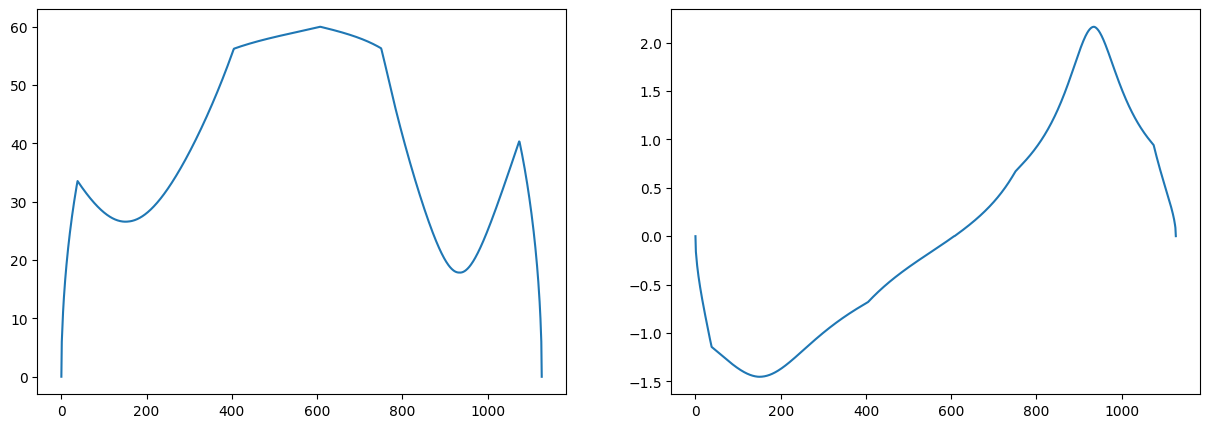

In [9]:
fig, (ax_v, ax_w) = plt.subplots(1, 2, figsize=(15, 5))

path = CubicBezier(
    [0, 0],
    [0, 50],
    [100, 0],
    [75, 50]
)

constraints = Constraints(60, 180, 180, 11, 0.1)
step = 0.1
mp = MotionProfile(path, constraints, step)
mp.generate(0.01, 0.01, 0, 0)
ax_v.plot(mp.vs)
ax_w.plot(mp.ws)
len(mp.ws)

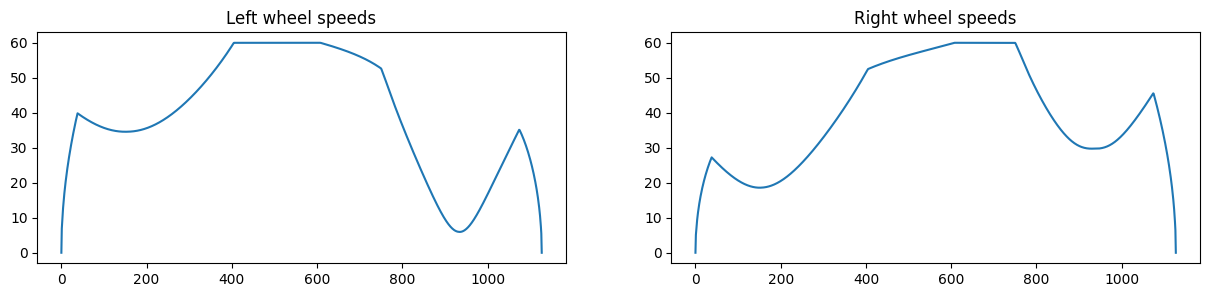

In [10]:
# Negative vels are ok?, oscillations

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(15, 3))
ax_left.set_title('Left wheel speeds')
ax_right.set_title('Right wheel speeds')

left_wheels = [mp.get_wheel_speeds(None, i)[0] for i in range(len(mp.vs))]
right_wheels = [mp.get_wheel_speeds(None, i)[1] for i in range(len(mp.vs))]

ax_left.plot(left_wheels)
ax_right.plot(right_wheels)

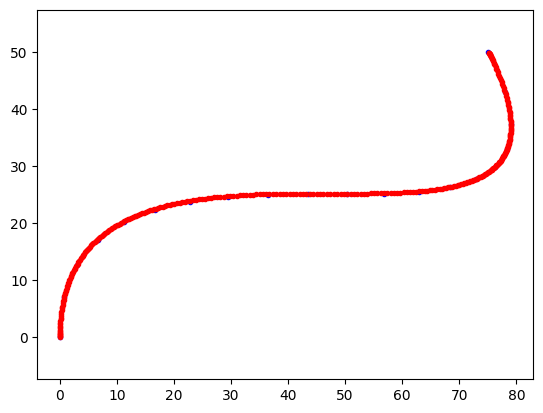

In [11]:
plt.axis('equal')
sim(mp)

ZeroDivisionError: float division by zero

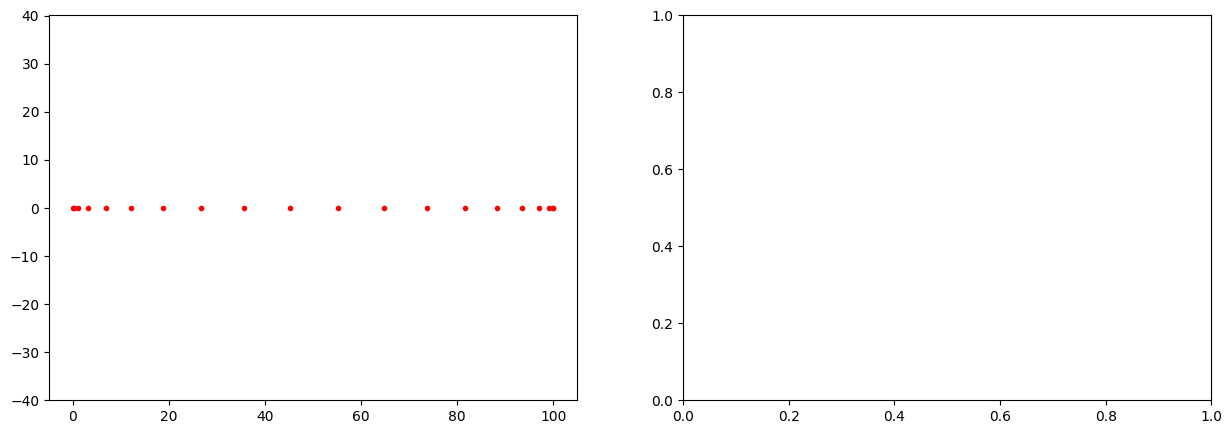

In [12]:
fig, (ax_curve, ax_v) = plt.subplots(1, 2, figsize=(15, 5))
qh = QuinticHermite(
    [0, 0],
    [1, 0],
    [0, 0],
    [100, 0],
    [0, 0],
    [0, 0]
)
for t in np.linspace(0, 1, 20):
    ax_curve.plot(*qh.calc(t), 'r.')
#     plt.arrow(*hermite.calc(t), hermite.d(t)[0], hermite.d(t)[1], head_width=2)
ax_curve.axis('equal')

hermite_mp = MotionProfile(qh, constraints, step)
hermite_mp.generate(0.01, 0, -2, 0)
ax_v.plot(hermite_mp.vs)
# errors on vertical paths due to high alpha?

In [ ]:
sim(hermite_mp)

In [ ]:
class Trajectory:
    def __init__(self, path, constraints, step):
        self.path = path
        self.constraints = constraints
        self.step = step
        
        
    def generate(self, start_v, end_v, start_w, end_w):
        vs = []
        ws = []
        curvatures = []

        v = start_v
        prev_w = start_w
        vs.append(v)
#         ws.append(prev_w)
        d = self.path.d(0)
        theta = math.atan2(d[1], d[0])
        
        t = self.step / math.hypot(*d)
        d = self.path.d(t)
        next_theta = math.atan2(d[1], d[0])
        w = (next_theta - theta) * (v / self.step)
        theta = next_theta
        ws.append(w)
        while t < self.path.max_t():
            d = self.path.d(t)
            d2 = self.path.d2(t)

            curvature = self.path.curvature(t, d, d2)
            curvatures.append(curvature)
            
            w = v * curvature
            a = (w - prev_w) * (v / self.step)
            prev_w = w
            
            max_acc = self.constraints.max_acc - abs(a * self.constraints.track_width / 2)
            v = min(constraints.max_speed(curvature), math.sqrt(v**2 + 2 * max_acc * self.step))
            
            if t > 0.9 and math.floor(t) > math.floor(t - self.step / math.hypot(*d)):
                print(w, a, max_acc, v)
                print(ws[-1])
                print()
            
            vs.append(v)
            ws.append(w)
            t += self.step / math.hypot(*d)

        v = end_v
        prev_w = end_w
        vs.append(v)
        ws.append(prev_w)
        d = self.path.d(1)
        
        i = len(vs) - 2
        while i > 0:
            curvature = curvatures.pop(-1)
            w = v * curvature
            a = (w - prev_w) * (v / self.step)
            prev_w = w
            
            max_acc = self.constraints.max_dec - abs(a * self.constraints.track_width / 2)
            v = min(constraints.max_speed(curvature), math.sqrt(v**2 + 2 * max_acc * self.step))
            
            if abs(v) < abs(vs[i]):
                vs[i] = v
            # Decide w by itself? (comment out)
            if abs(w) < abs(ws[i]):
                ws[i] = w
            i -= 1
        
        self.vs = vs
        self.ws = ws
    
    def get_wheel_speeds(self, dist):
        i = math.ceil(dist / self.step)
        left_speed = self.vs[i] - self.ws[i] * constraints.track_width / 2
        right_speed = self.vs[i] + self.ws[i] * constraints.track_width / 2
        return (left_speed, right_speed)

In [ ]:
fig, (ax_v, ax_w) = plt.subplots(1, 2, figsize=(15, 3))

# spline = BezierSpline([
#     CubicBezier(
#         [0, 0],
#         [19, 28],
#         [39, -7],
#         [47, 22]
#     ),
#     CubicBezier(
#         [47, 22],
#         [52, 43],
#         [33, 60],
#         [0, 31]
#     )
# ])
part1 = CubicBezier(
        [0, 0],
        [0, 20],
        [30, -30],
        [30, 0]
    )
part2 = CubicBezier(
        [30, 0],
        [30, 30],
        [10, 20],
        [10, 40]
    )
spline = BezierSpline([
    part1,
    part2
])
traj = Trajectory(spline, constraints, 0.01)
traj.generate(0.1, 0, 0, 0)
ax_v.plot(traj.vs)
ax_w.plot(traj.ws)
# ax_v.plot(traj.vs[540:600])
# ax_w.plot(traj.ws[540:600])
# ax_v.plot(28, 36, 'r.')
# ax_v.plot(27, 36, 'r.')
# ax_v.plot(26, 36, 'r.')

mp1 = MotionProfile(part1, constraints, step)
mp2 = MotionProfile(part2, constraints, step)
mp1.generate(0, 0, 0, 0)
mp2.generate(0, 0, 0, 0)

In [ ]:
sim(traj)
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(10, 7)